In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.8.0+cu126
True
NVIDIA GeForce GTX 1070


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Load Dataset

In [4]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
input_channels = 1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

## Model

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # MNIST -> 28x28 -> pool -> 14x14 -> pool -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=10, input_channels=input_channels).to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train_model(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(trainloader)

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return test_loss / len(testloader), 100 * correct / total


## Training

In [8]:
epochs = 3
train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):
    train_loss = train_model(model, trainloader, criterion, optimizer, device)
    test_loss, acc = evaluate_model(model, testloader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {acc:.2f}%")

Epoch [1/3] Train Loss: 0.1546 | Test Loss: 0.0502 | Accuracy: 98.27%


Epoch [2/3] Train Loss: 0.0448 | Test Loss: 0.0362 | Accuracy: 98.83%


Epoch [3/3] Train Loss: 0.0292 | Test Loss: 0.0381 | Accuracy: 98.74%


## Training Curves

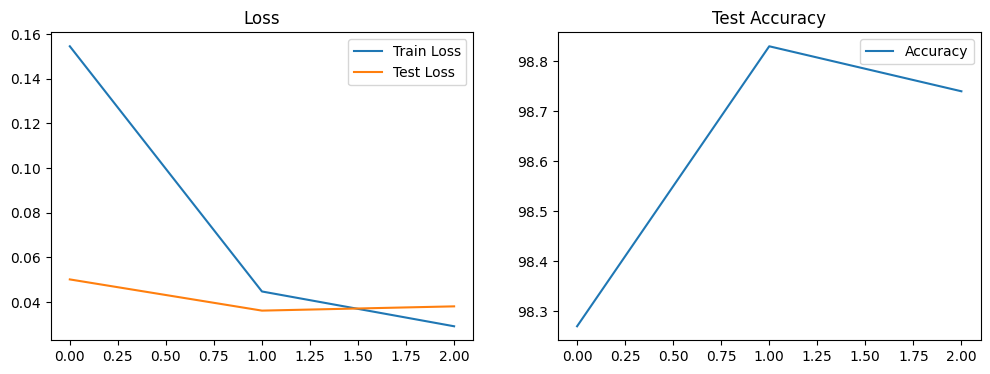

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(accuracies, label="Accuracy")
plt.legend()
plt.title("Test Accuracy")

plt.show()

In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

Predicted: 7 2 1 0 4 1 4 9
GroundTruth: 7 2 1 0 4 1 4 9


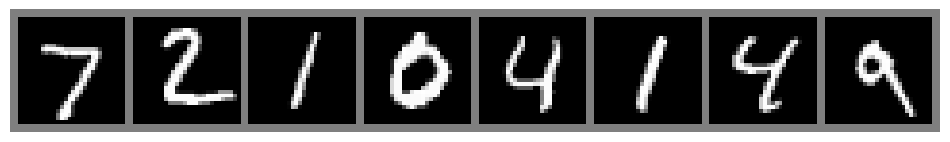

In [11]:
import numpy as np

# Class labels
classes = [str(i) for i in range(10)]

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Run model predictions
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show a few
plt.figure(figsize=(12,6))
imshow(torchvision.utils.make_grid(images[:8].cpu(), nrow=8))
print("Predicted:", " ".join(f"{classes[predicted[j]]}" for j in range(8)))
print("GroundTruth:", " ".join(f"{classes[labels[j]]}" for j in range(8)))

## Interactive Demo

In [ ]:
import napari 
import cv2
viewer = napari.Viewer()

In [34]:
aux = viewer.export_figure(scale_factor=0.15)

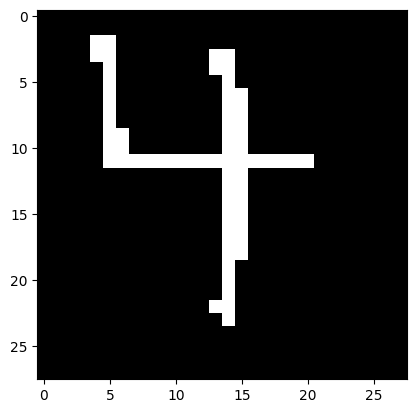

In [35]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = cv2.resize(aux, dsize=(28, 28)) #, interpolation=cv2.INTER_CUBIC)
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

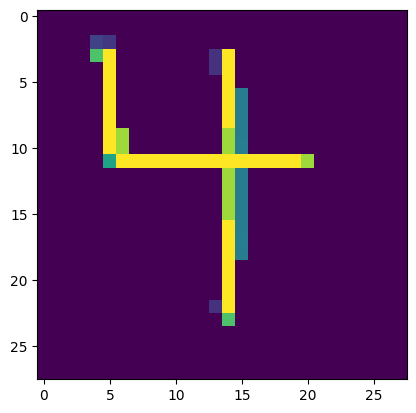

In [40]:
plt.imshow(gray)
plt.show()

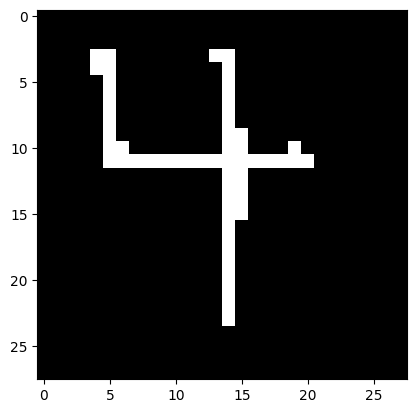

In [28]:
res = cv2.resize(gray, dsize=(28, 28)) #, interpolation=cv2.INTER_CUBIC)
plt.imshow(res, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [29]:
mnist_image_tensor = torch.from_numpy(res).unsqueeze(0).unsqueeze(0).float().to(device)

In [30]:
# Run model predictions
model.eval()
outputs = model(mnist_image_tensor)
_, predicted = torch.max(outputs, 1)


In [32]:
predicted.item()

8